# Perceptrón aplicado a Olivetti

### 1. Lectura


Cargamos el dataset Olivetti Faces (400 imágenes de caras, 64x64 píxeles).

Descargando caras Olivetti...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Dimensiones X: (400, 4096)
Dimensiones y: (400,)


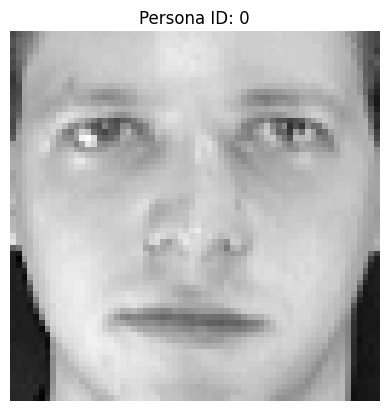

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

# 1. Cargar Olivetti
print("Descargando caras Olivetti...")
olivetti = fetch_olivetti_faces()

# 2. X e y
X = olivetti.data.astype(np.float16)
y = olivetti.target.astype(np.uint)



print("Dimensiones X:", X.shape)

print("Dimensiones y:", y.shape)


plt.imshow(X[0].reshape(64, 64), cmap='gray')
plt.title(f"Persona ID: {y[0]}")
plt.axis('off')
plt.show()

### 2. Partición del corpus

Dividimos en Train (70%) y Test (30%) usando estratificación para asegurar que haya fotos de todas las personas en ambos conjuntos.

In [3]:
from sklearn.model_selection import train_test_split


# Subimos test_size a 0.3 para tener 3 fotos de cada persona en test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")

X_train: (280, 4096)
X_test:  (120, 4096)


### 3. Implementación del algoritmo Perceptrón

Implementación del algoritmo de aprendizaje Perceptrón, partiendo de pesos nulos.

Recibe como parámetros de entrada:

- Matriz de muestras de entrenamiento `X`, de tamaño $N\times D$,
- Matriz (vector columna) de etiquetas de clase `y`, de tamaño $N\times 1$,
- Valores de los hiperparámetros del algoritmo (a optimizar de manera experimental):
    - Variable de margen `b` $\ge 0$,
    - Factor de aprendizaje `a` $> 0$,
    - Número máximo de iteraciones `K` $> 0$.

Devuelve:

- Matriz de pesos optimizados `W`, en notación homogénea, de tamaño $(1+D)\times C$,  
- Número de muestras de train incorrectamente clasificadas `E` durante la última iteración realizada,
- Número de iteraciones ejecutadas `k`.

In [4]:
def perceptron(X, y, b=0.1, a=1.0, K=200):
    N, D = X.shape;                               # N: num. muestras; D: dimensionalidad
    Y = np.unique(y);                             # Y: Conjunto etiquetas de clase
    C = Y.size;                                   # C: número de clases
    W = np.zeros((1+D, C));                       # Inicialización matriz de pesos nulos
    for k in range(1, K+1):
        E = 0                                     # E: Contador de errores de clasificación
        for n in range(N):
            xn = np.array([1, *X[n, :]]);         # xn: vector x en notación compacta
            yn = np.squeeze(np.where(Y==y[n]));   # yn: etiq. de clase correcta en {0,...,C-1}
            gn = W[:,yn] @ xn;                    # gn: valor f.discr. de la clase correcta
            err = False;
            for c in np.arange(C):
                if c != yn:
                    if W[:,c] @ xn + b >= gn:     # ¿Se clasifica mal la muestra xn?
                        W[:, c] = W[:, c] - a*xn; # Ajustamos pesos de la clase incorrecta
                        err = True;
            if err:
                W[:, yn] = W[:, yn] + a*xn;       # Ajustamos pesos de la clase correcta
                E = E + 1;
        if E == 0:                                # Algoritmo converge, finalizamos entrenamiento.
            break;
    return W, E, k

**Nota 1:** el carácter `*` delante de una secuencia actúa como [operador de desempaquetado (unpacking operator)]((https://peps.python.org/pep-0448/)).

**Nota 2:** el [operador `@`](https://peps.python.org/pep-0465/) denota multiplicación de matrices.

Conviene resaltar que **el valor `E` devuelto no nos sirve para calcular la tasa de error de train**, ya que los pesos se modifican a lo largo de la iteración. La tasa de error en train se debe calcular con unos pesos fijos (invariables) para todas las muestras, p.e. al finalizar el entrenamiento, o incluso al final de cada iteración. `E` solo nos sirve para conocer el número de actualizaciones de pesos realizadas en la última iteración del algoritmo.

### 4. Aprendizaje de un clasificador lineal con Perceptrón

Perceptrón devuelve una matriz de pesos optimizados $\mathbf{W}^*$ que minimiza el número de errores de entrenamiento (con margen `b`):

$$\mathbf{W}^*=\operatorname*{argmin}_{\mathbf{W}=(\boldsymbol{w}_1,\dotsc,\boldsymbol{w}_C)}\sum_n\;\mathbb{I}\biggl(\max_{c\neq y_n}\;(\boldsymbol{w}_c^t\boldsymbol{x}_n+b) \;>\; \boldsymbol{w}_{y_n}^t\boldsymbol{x}_n\biggr)$$

In [5]:
# Aumentamos K a 2000
W, E, k = perceptron(X_train, y_train, b=0.1, a=1.0, K=2000)

print("Iteraciones:", k)
print("Errores última vuelta:", E)


Iteraciones: 47
Errores última vuelta: 0


### 5. Cálculo de tasas de error

**Tasa de error en train:**

In [6]:
# 1. Preparar datos de Train (añadir columna de 1s)
X_train_h = np.hstack([np.ones((len(X_train), 1)), X_train])

# 2. Predecir sobre Train
y_train_pred = np.argmax(X_train_h @ W, axis=1)

# 3. Calcular error
errores_train = np.count_nonzero(y_train_pred != y_train)
tasa_error_train = errores_train / len(X_train)

print(f"Errores en Train: {errores_train}/{len(X_train)}")
print(f"Tasa de error en Train: {tasa_error_train:.2%}")

Errores en Train: 0/280
Tasa de error en Train: 0.00%


**Tasa de error en test:**

Errores en Test: 9/120
Tasa de error en Test: 7.50%
Tasa de Acierto (Accuracy): 92.50%


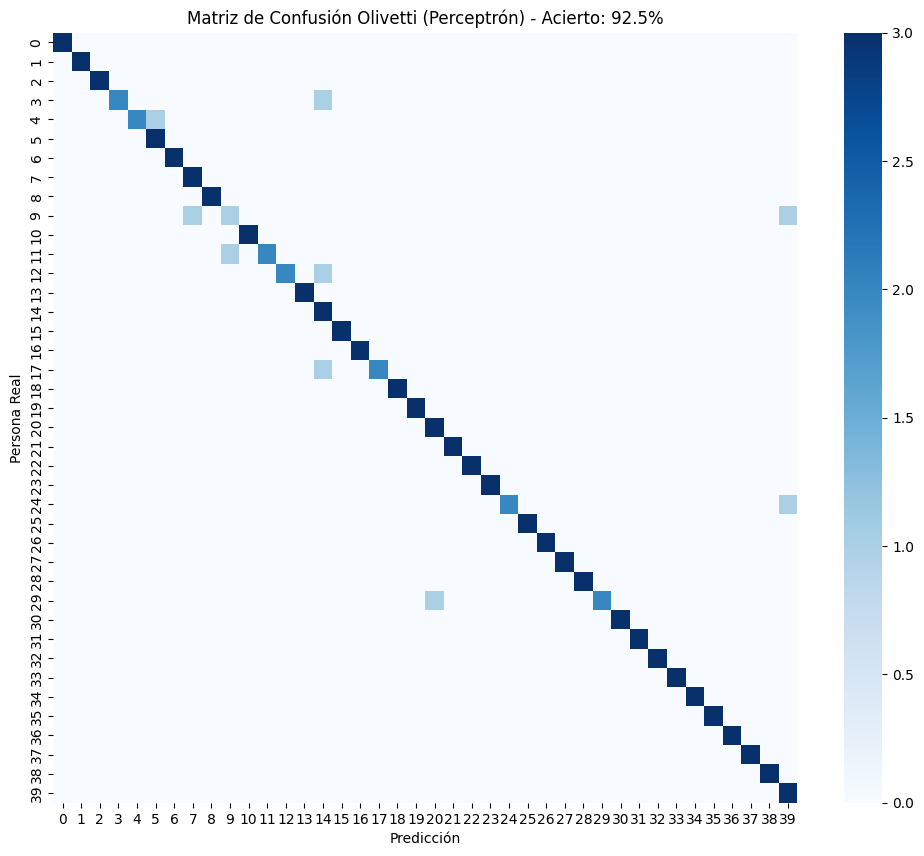

In [7]:
# --- Evaluación Final en Test ---
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 1. Preparar datos de Test
X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test])

# 2. Predecir
y_pred = np.argmax(X_test_h @ W, axis=1)

# 3. Calcular nota
errores_test = np.count_nonzero(y_pred != y_test)
tasa_error_test = errores_test / len(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Errores en Test: {errores_test}/{len(X_test)}")
print(f"Tasa de error en Test: {tasa_error_test:.2%}")
print(f"Tasa de Acierto (Accuracy): {acc:.2%}")

# 4. Gráfica
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title(f'Matriz de Confusión Olivetti (Perceptrón) - Acierto: {acc:.1%}')
plt.ylabel('Persona Real')
plt.xlabel('Predicción')
plt.show()